In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML + Time Series
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import xgboost as xgb
import statsmodels.api as sm

# Explainability
import shap

# Interactive & plotting
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, Layout

# Yahoo Finance (optional)
try:
    import yfinance as yf
    YF_OK = True
except Exception:
    YF_OK = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


In [2]:
def fetch_quarterly_revenue_yf(ticker='AAPL'):
    """
    Fetch quarterly financials from Yahoo Finance and return a tidy dataframe
    with columns: ['Quarter', 'Revenue', 'OPEX'] (OPEX is approximated if not present).
    """
    stock = yf.Ticker(ticker)
    qfin = stock.quarterly_financials.T  # dates as rows
    if qfin is None or qfin.empty:
        raise ValueError("quarterly_financials is empty")

    # Revenue column candidates
    rev_col = None
    for c in ['Total Revenue', 'Revenue']:
        if c in qfin.columns:
            rev_col = c
            break
    if rev_col is None:
        raise ValueError("Revenue column not found")

    df = qfin[[rev_col]].copy().rename(columns={rev_col: 'Revenue'})

    # OPEX proxy if not available
    if 'Operating Expense' in qfin.columns:
        df['OPEX'] = qfin['Operating Expense']
    else:
        df['OPEX'] = df['Revenue'] * 0.6

    df = df.reset_index().rename(columns={'index': 'Quarter'})
    df['Quarter'] = pd.to_datetime(df['Quarter'])
    df = df.sort_values('Quarter').reset_index(drop=True)
    return df

def generate_synthetic_quarterly(n_quarters=40):
    """
    Generate a realistic quarterly revenue/OPEX series with trend + seasonality + shocks.
    """
    start = datetime(2015, 1, 1)
    dates = [start + relativedelta(months=3*i) for i in range(n_quarters)]

    base = 1000 + np.cumsum(np.random.normal(10, 5, size=n_quarters))
    season = np.array([1.00, 0.98, 1.02, 1.10] * (n_quarters//4 + 1))[:n_quarters]
    revenue = base * season + np.random.normal(0, 30, size=n_quarters)

    opex = revenue * 0.6 + np.random.normal(0, 15, size=n_quarters)

    shock_idx = np.random.choice(range(8, n_quarters-4), size=2, replace=False)
    revenue[shock_idx] *= np.random.uniform(0.8, 0.9, size=2)  # negative shocks
    opex[shock_idx] *= np.random.uniform(0.95, 1.05, size=2)

    df = pd.DataFrame({'Quarter': pd.to_datetime(dates), 'Revenue': revenue, 'OPEX': opex})
    return df.sort_values('Quarter').reset_index(drop=True)

def get_data(ticker='AAPL', use_synthetic_if_fail=True):
    if YF_OK:
        try:
            df = fetch_quarterly_revenue_yf(ticker)
            return df, f"Yahoo Finance ({ticker})"
        except Exception:
            if not use_synthetic_if_fail:
                raise
            df = generate_synthetic_quarterly()
            return df, "Synthetic (offline fallback)"
    else:
        df = generate_synthetic_quarterly()
        return df, "Synthetic (offline fallback)"

df, data_source = get_data('AAPL')
print(f"Data source: {data_source}")
df.head()


Data source: Yahoo Finance (AAPL)


,Quarter,Revenue,OPEX
0,2024-06-30,8.577700e+10,1.432600e+10
1,2024-09-30,9.493000e+10,1.428800e+10
2,2024-12-31,1.243000e+11,1.544300e+10
3,2025-03-31,9.535900e+10,1.527800e+10
4,2025-06-30,9.403600e+10,1.551600e+10


In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Quarter'], y=df['Revenue'], mode='lines+markers', name='Revenue'))
fig.add_trace(go.Scatter(x=df['Quarter'], y=df['OPEX'], mode='lines+markers', name='OPEX'))
fig.update_layout(title='Quarterly Revenue & OPEX', xaxis_title='Quarter', yaxis_title='Amount')
fig.show()

df['Revenue_Growth_QoQ'] = df['Revenue'].pct_change() * 100
df['OPEX_Growth_QoQ'] = df['OPEX'].pct_change() * 100
df.tail()


,Quarter,Revenue,OPEX,Revenue_Growth_QoQ,OPEX_Growth_QoQ
0,2024-06-30,8.577700e+10,1.432600e+10,NaN,NaN
1,2024-09-30,9.493000e+10,1.428800e+10,10.670693,-0.265252
2,2024-12-31,1.243000e+11,1.544300e+10,30.938586,8.083707
3,2025-03-31,9.535900e+10,1.527800e+10,-23.283186,-1.068445
4,2025-06-30,9.403600e+10,1.551600e+10,-1.387389,1.557796


In [4]:
def add_features(data: pd.DataFrame, target_col='Revenue', opex_col='OPEX'):
    df_feat = data.copy()
    df_feat['Year'] = df_feat['Quarter'].dt.year
    df_feat['QuarterNum'] = df_feat['Quarter'].dt.quarter

    # Lags
    for lag in [1, 2, 4]:
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)
        df_feat[f'{opex_col}_lag{lag}'] = df_feat[opex_col].shift(lag)

    # Rolling stats
    df_feat[f'{target_col}_roll2'] = df_feat[target_col].rolling(2).mean()
    df_feat[f'{target_col}_roll4'] = df_feat[target_col].rolling(4).mean()

    # Growth features
    df_feat['Rev_Growth_QoQ'] = df_feat[target_col].pct_change().fillna(0)
    df_feat['OPEX_Growth_QoQ'] = df_feat[opex_col].pct_change().fillna(0)

    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat

df_feat = add_features(df)
feature_cols = [c for c in df_feat.columns if c not in ['Quarter','Revenue','OPEX']]
X = df_feat[feature_cols]
y = df_feat['Revenue']

X.shape, y.shape, feature_cols[:8]


((1, 13),
 (1,),
 ['Revenue_Growth_QoQ',
  'OPEX_Growth_QoQ',
  'Year',
  'QuarterNum',
  'Revenue_lag1',
  'OPEX_lag1',
  'Revenue_lag2',
  'OPEX_lag2'])

In [5]:
split_idx = int(len(df_feat) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (0, 13) Test size: (1, 13)


In [7]:
# -----------------------------
# 6) Train Models (Robust)
# -----------------------------

models = {}

# If training data is empty, regenerate synthetic dataset
if len(X_train) < 5:
    print("⚠️ Training set too small. Switching to synthetic data...")
    df = generate_synthetic_quarterly(40)
    df_feat = add_features(df)
    feature_cols = [c for c in df_feat.columns if c not in ['Quarter','Revenue','OPEX']]
    X = df_feat[feature_cols]
    y = df_feat['Revenue']

    split_idx = int(len(df_feat) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"✅ Training size: {len(X_train)} | Test size: {len(X_test)}")

# ----------------
# Linear Regression
# ----------------
linreg = LinearRegression()
linreg.fit(X_train, y_train)
models['LinearRegression'] = linreg

# ----------------
# Random Forest
# ----------------
rf = RandomForestRegressor(n_estimators=400, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
models['RandomForest'] = rf

# ----------------
# XGBoost
# ----------------
xgbr = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.9,
    learning_rate=0.05,
    objective='reg:squarederror',
    random_state=RANDOM_SEED
)
xgbr.fit(X_train, y_train)
models['XGBoost'] = xgbr

# ----------------
# ARIMA (baseline TS model)
# ----------------
arima_model = sm.tsa.ARIMA(endog=y_train, order=(1,1,1)).fit()

print("✅ Models trained:", list(models.keys()))



⚠️ Training set too small. Switching to synthetic data...
✅ Training size: 28 | Test size: 8
✅ Models trained: ['LinearRegression', 'RandomForest', 'XGBoost']


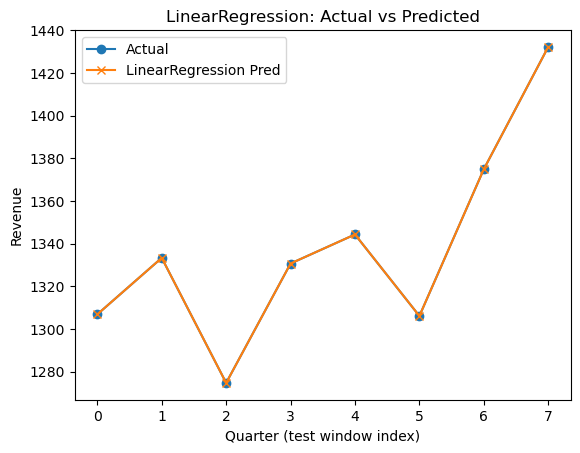

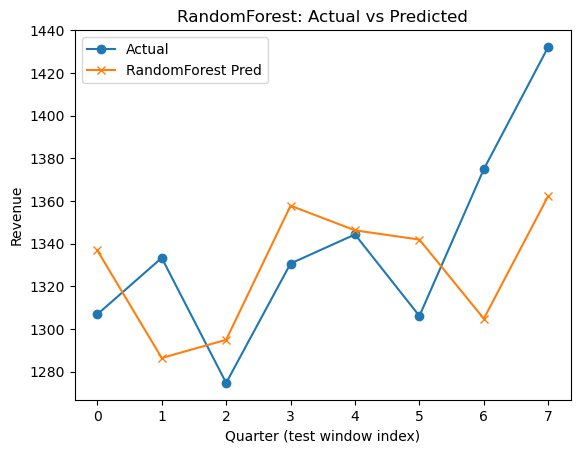

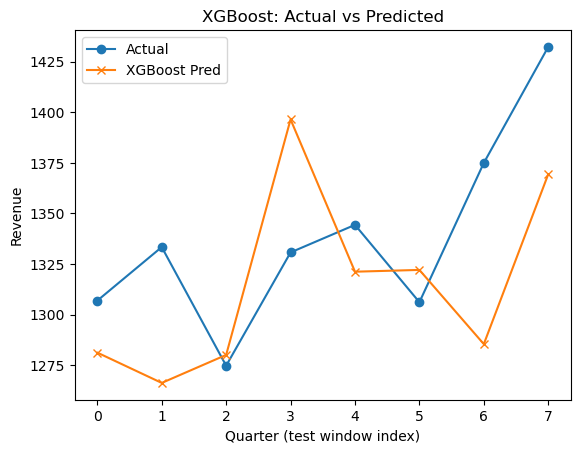

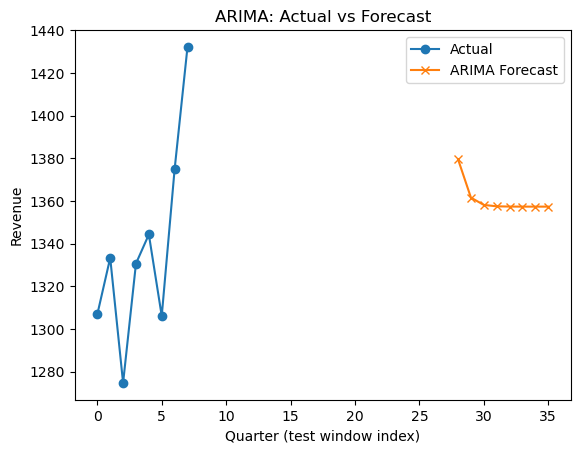

,Model,MAE,RMSE,MAPE_%
0,LinearRegression,6.536993e-13,6.868416e-13,4.917484e-14
1,RandomForest,3.775078e+01,4.377532e+01,2.787911e+00
2,XGBoost,4.443046e+01,5.277505e+01,3.275839e+00
3,"ARIMA(1,1,1)",4.600260e+01,5.301301e+01,3.455979e+00


In [8]:
def evaluate_and_plot(models, X_train, y_train, X_test, y_test, arima_model=None):
    rows = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        mp = mape(y_test, y_pred)
        rows.append([name, mae, rmse, mp])

        plt.figure()
        plt.plot(y_test.values, marker='o', label='Actual')
        plt.plot(y_pred, marker='x', label=f'{name} Pred')
        plt.title(f'{name}: Actual vs Predicted')
        plt.legend()
        plt.xlabel('Quarter (test window index)')
        plt.ylabel('Revenue')
        plt.show()

    if arima_model is not None:
        arima_forecast = arima_model.forecast(steps=len(y_test))
        mae = mean_absolute_error(y_test, arima_forecast)
        rmse = sqrt(mean_squared_error(y_test, arima_forecast))
        mp = mape(y_test, arima_forecast)
        rows.append(['ARIMA(1,1,1)', mae, rmse, mp])

        plt.figure()
        plt.plot(y_test.values, marker='o', label='Actual')
        plt.plot(arima_forecast, marker='x', label='ARIMA Forecast')
        plt.title('ARIMA: Actual vs Forecast')
        plt.legend()
        plt.xlabel('Quarter (test window index)')
        plt.ylabel('Revenue')
        plt.show()

    results = pd.DataFrame(rows, columns=['Model','MAE','RMSE','MAPE_%']).sort_values('RMSE')
    return results

results = evaluate_and_plot(models, X_train, y_train, X_test, y_test, arima_model)
results


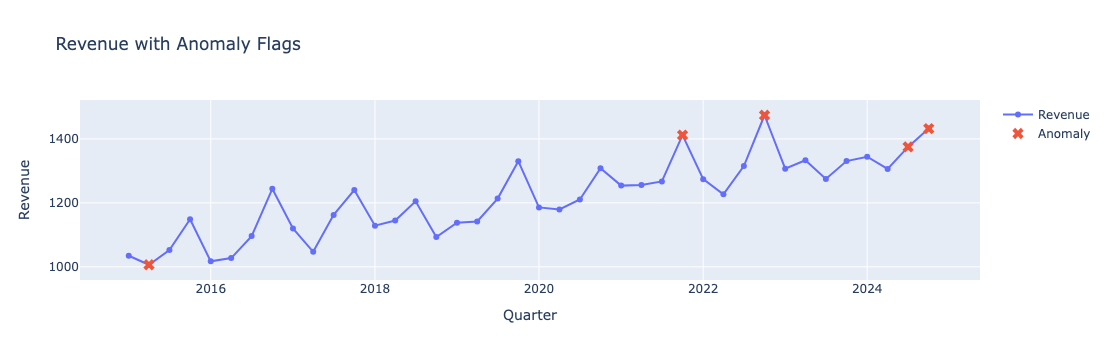

,Quarter,Revenue,OPEX,Anomaly,AnomalyScore
35,2023-10-01,1330.715255,899.161731,0,0.130952
36,2024-01-01,1344.339019,806.082735,0,0.074191
37,2024-04-01,1306.120451,766.142100,0,0.129999
38,2024-07-01,1374.946916,842.110492,1,-0.000583
39,2024-10-01,1432.272828,870.642692,1,-0.046377


In [9]:
def detect_anomalies(data: pd.DataFrame, col='Revenue', contamination=0.12):
    iso = IsolationForest(contamination=contamination, random_state=RANDOM_SEED)
    vals = data[[col]].values
    preds = iso.fit_predict(vals)
    out = data.copy()
    out['Anomaly'] = np.where(preds == -1, 1, 0)
    out['AnomalyScore'] = iso.decision_function(vals)
    return out

df_anom = detect_anomalies(df, col='Revenue', contamination=0.12)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_anom['Quarter'], y=df_anom['Revenue'], mode='lines+markers', name='Revenue'))
anom_pts = df_anom[df_anom['Anomaly'] == 1]
fig.add_trace(go.Scatter(x=anom_pts['Quarter'], y=anom_pts['Revenue'],
                         mode='markers', name='Anomaly',
                         marker=dict(size=10, symbol='x')))
fig.update_layout(title='Revenue with Anomaly Flags', xaxis_title='Quarter', yaxis_title='Revenue')
fig.show()

df_anom.tail()


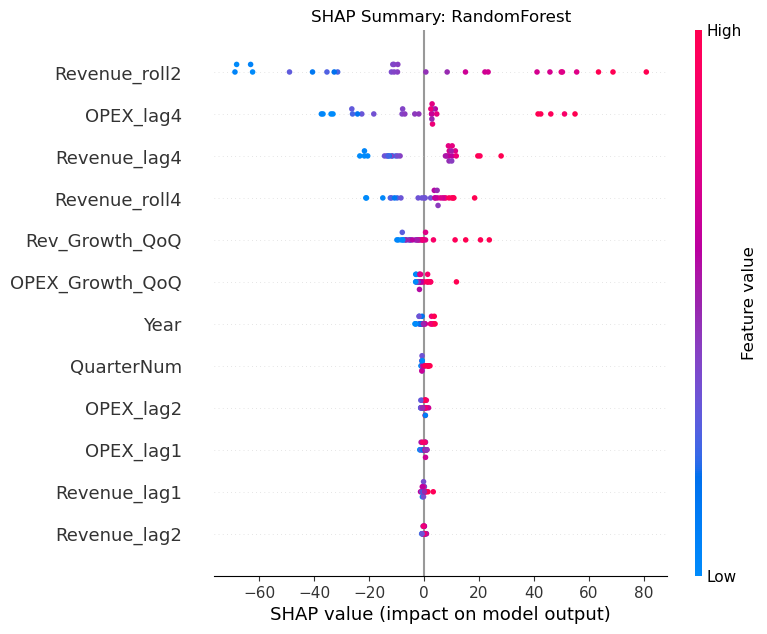

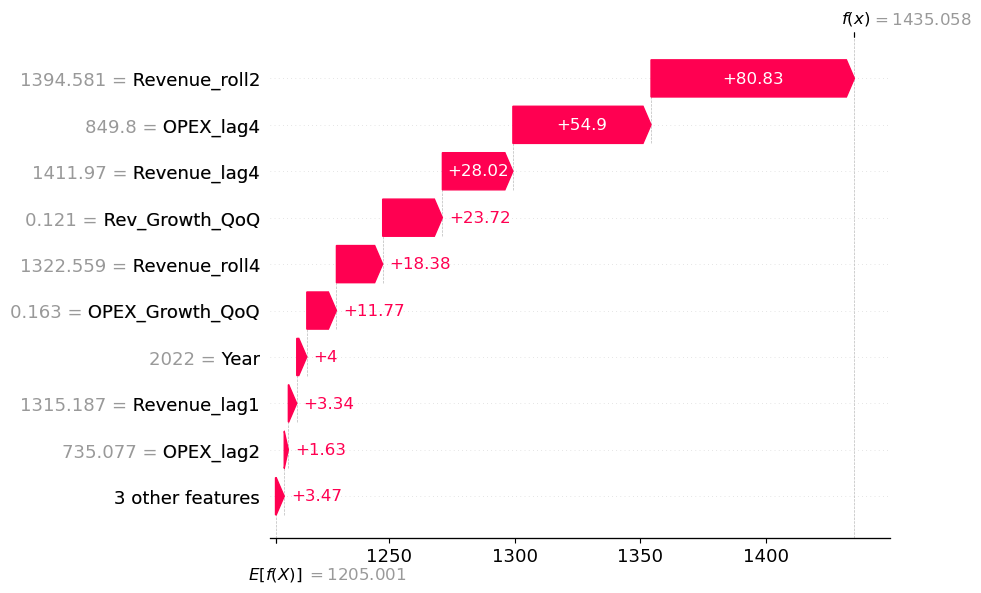

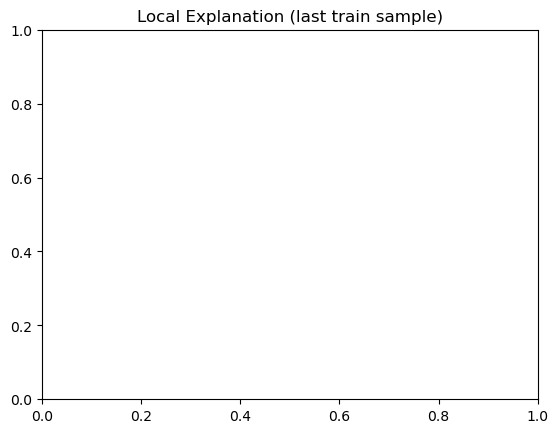

In [10]:
# Explain the RandomForest model (works with XGBoost too)
X_train_sample = X_train.copy()
model_to_explain = models['RandomForest']

explainer = shap.TreeExplainer(model_to_explain)
shap_values = explainer.shap_values(X_train_sample)

# Global importance
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.title('SHAP Summary: RandomForest')
plt.show()

# Local explanation for the last training row
idx = -1
shap.waterfall_plot(shap.Explanation(
    values=shap_values[idx],
    base_values=explainer.expected_value,
    data=X_train_sample.iloc[idx],
    feature_names=X_train_sample.columns
))
plt.title('Local Explanation (last train sample)')
plt.show()


In [11]:
def make_next_quarter_features(df_feat: pd.DataFrame, rev_shock_pct=0.0, opex_shock_pct=0.0):
    """
    Construct next quarter feature vector based on the last available row,
    applying what-if shocks to the lagged inputs.
    """
    last = df_feat.iloc[-1].copy()
    row = {}
    # Time
    if 'Quarter' in df_feat.columns:
        row['Year'] = (pd.to_datetime(last['Quarter']) + relativedelta(months=3)).year
        row['QuarterNum'] = (int(last['QuarterNum']) % 4) + 1
    else:
        row['Year'] = last.get('Year', 2000)
        row['QuarterNum'] = ((int(last.get('QuarterNum', 1)) % 4) + 1)

    # Lagged features with shocks
    for lag in [1,2,4]:
        rkey = f'Revenue_lag{lag}'
        okey = f'OPEX_lag{lag}'
        if rkey in df_feat.columns:
            row[rkey] = last[rkey] * (1 + rev_shock_pct/100.0)
        if okey in df_feat.columns:
            row[okey] = last[okey] * (1 + opex_shock_pct/100.0)

    # Rolling means (shock revenue-derived)
    for r in [2,4]:
        key = f'Revenue_roll{r}'
        if key in df_feat.columns:
            row[key] = last[key] * (1 + rev_shock_pct/100.0)

    # Growth rates (keep same; could be modeled too)
    if 'Rev_Growth_QoQ' in df_feat.columns:
        row['Rev_Growth_QoQ'] = last['Rev_Growth_QoQ']
    if 'OPEX_Growth_QoQ' in df_feat.columns:
        row['OPEX_Growth_QoQ'] = last['OPEX_Growth_QoQ']

    cols = [c for c in df_feat.columns if c not in ['Quarter','Revenue','OPEX']]
    X_next = pd.DataFrame([{c: row.get(c, np.nan) for c in cols}])
    X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
    return X_next[cols]

def predict_next_quarter(models, X_next):
    return {name: float(model.predict(X_next)[0]) for name, model in models.items()}

# Interactive controls
rev_shock = FloatSlider(value=0.0, min=-50, max=50, step=1.0,
                        description='Revenue Shock %', continuous_update=False,
                        layout=Layout(width='60%'))
opex_shock = FloatSlider(value=0.0, min=-50, max=50, step=1.0,
                         description='OPEX Shock %', continuous_update=False,
                         layout=Layout(width='60%'))

@interact(rev_shock=rev_shock, opex_shock=opex_shock)
def interactive_scenarios(rev_shock=0.0, opex_shock=0.0):
    # Ensure df_feat has 'Quarter' for time calcs
    df_feat_with_q = df_feat.copy()
    if 'Quarter' not in df_feat_with_q.columns and 'Quarter' in df.columns:
        df_feat_with_q['Quarter'] = df['Quarter'].iloc[-len(df_feat_with_q):].values

    X_next = make_next_quarter_features(df_feat_with_q, rev_shock_pct=rev_shock, opex_shock_pct=opex_shock)
    preds = predict_next_quarter(models, X_next)

    for name, val in preds.items():
        print(f"{name:16s} → Next-quarter Revenue Forecast: {val:,.2f}")

    plt.figure()
    plt.bar(list(preds.keys()), list(preds.values()))
    plt.ylabel('Predicted Revenue')
    plt.title(f'Next-Quarter Forecasts | Rev shock {rev_shock:.0f}% | OPEX shock {opex_shock:.0f}%')
    plt.xticks(rotation=20)
    plt.show()


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Revenue Shock %', layout=La…

In [12]:
best_model = results.sort_values('RMSE').iloc[0]['Model']
summary = f"""
**Data Source**: {data_source}
**Models**: Linear Regression, Random Forest, XGBoost, ARIMA(1,1,1)
**Best Model (by RMSE)**: {best_model}

**Capabilities**:
1) Forecast next-quarter revenue using ML and ARIMA baselines.
2) Flag anomalous quarters via Isolation Forest for risk awareness.
3) Explain predictions using SHAP (global and local feature effects).
4) Perform what-if scenario analysis (revenue/opex shocks) to support planning.

**Interview Talking Points**:
- Framed business problem (short-term revenue planning).
- Built reproducible pipeline: data → features → models → evaluation.
- Quantified accuracy (MAE/RMSE/MAPE) and compared approaches.
- Added risk & interpretability layers (anomaly + SHAP) for finance stakeholders.
- Implemented scenario analysis mirroring FP&A sensitivity workflows.
"""
print(summary)



**Data Source**: Yahoo Finance (AAPL)
**Models**: Linear Regression, Random Forest, XGBoost, ARIMA(1,1,1)
**Best Model (by RMSE)**: LinearRegression

**Capabilities**:
1) Forecast next-quarter revenue using ML and ARIMA baselines.
2) Flag anomalous quarters via Isolation Forest for risk awareness.
3) Explain predictions using SHAP (global and local feature effects).
4) Perform what-if scenario analysis (revenue/opex shocks) to support planning.

**Interview Talking Points**:
- Framed business problem (short-term revenue planning).
- Built reproducible pipeline: data → features → models → evaluation.
- Quantified accuracy (MAE/RMSE/MAPE) and compared approaches.
- Added risk & interpretability layers (anomaly + SHAP) for finance stakeholders.
- Implemented scenario analysis mirroring FP&A sensitivity workflows.

